# Spike-time autocorrelations, and maps of open field, light and dark trials

We first test on one session and then do the analysis for all sessions

In [2]:
%load_ext autoreload
%autoreload 2
%run ~/repo/autopi_analysis_bk/Jazi_et.al_2023_noInt/setup_project.py
%run ~/repo/autopi_analysis_bk/Jazi_et.al_2023_noInt/neuronAutopi.py

prepareSessionsForSpatialAnalysisProject(sSesList,myProject.sessionList)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Project name: autopi_ca1
dataPath: /ext_drives/d80/Jazi_etal_2023_noInter/autopi_ca1
dlcModelPath: /adata/models
Reading /ext_drives/d80/Jazi_etal_2023_noInter/autopi_ca1/sessionList
We have 39 testing sessions in the list
See myProject and sSesList objects
Loading Animal_pose and Spike_train, sSes.ap and sSes.cg


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [00:13<00:00,  2.80it/s]

Loading ses.trial_table_simple as ses.trials
Create condition intervals in ses.intervalDict


In [3]:
for ses, sSes in tqdm(zip(myProject.sessionList,sSesList)):
    getSearchHomingIntervals(ses,sSes)

39it [00:00, 47.78it/s]


In [4]:
def getAutoCorr(ses,sSes,binSize,minTime,maxTime):
    for n in sSes.cg.neuron_list:
        n.spike_train.unset_intervals()
        n.spike_train.spike_time_autocorrelation(bin_size_sec=binSize,min_sec=minTime, max_sec=maxTime)
    
    histoList = [n.spike_train.st_autocorrelation_histogram[0] for n in sSes.cg.neuron_list]
    histoStack = np.stack(histoList, axis=0)  
    return histoStack

Create spike-time autocorrelations of different types and save in a dictionary

In [5]:
binSizes = [0.0005,0.001]
minTimes = [-0.025, -0.200]
maxTimes = [0.025, 0.200]
keys = [25,200]

In [9]:
myAutos = {}
# loop for the different spike time autocorrelation types
for binSize,minTime,maxTime,key in zip(binSizes,minTimes,maxTimes,keys):
    aList=np.concatenate([getAutoCorr(ses,sSes,binSize,minTime,maxTime) for ses,sSes in zip(myProject.sessionList,sSesList)])
    n=sSesList[0].cg.neuron_list[0]
    time = n.spike_train.mid_point_from_edges(n.spike_train.st_autocorrelation_histogram[1])
    myAutos[key] = {"auto":aList, "time":time}

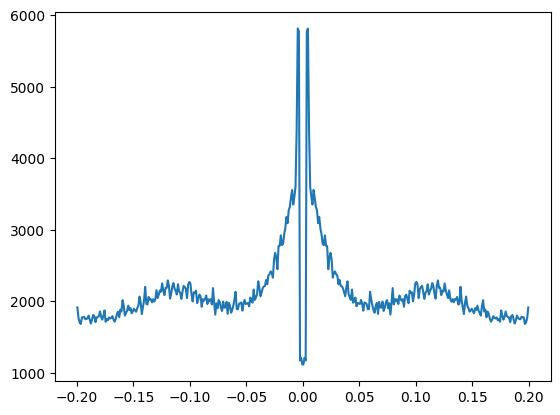

In [10]:
plt.plot(myAutos[200]["time"],myAutos[200]["auto"][0])

In [11]:
fn=myProject.dataPath+"/results/myAutos.pickle"
print("Saving:",fn)
with open(fn, 'wb') as handle:
    pickle.dump(myAutos, handle)

Saving: /ext_drives/d80/Jazi_etal_2023_noInter/autopi_ca1/results/myAutos.pickle


To simplify the stacking of the maps, we will only get one map type per function.

We can calculate all the intervals we need for the 3 maps (circ80, light, dark). We will need access to the data in ses and sSes.

In [12]:
def getMaps(ses,sSes,interName="dark",onlyArena=False):
    """
    Get all the maps of the data within the intervals of interest
    """
    xy_range=np.array([[-50,-90],[50,60]])
    sSes.ap.set_intervals(ses.intervalDict[interName])
    
    if onlyArena:
        # this should come after setting the time intervals, will be reset when calling sSes.ap.set_intervals again
        sSes.ap.invalid_outside_spatial_area(environment_shape= "circle",radius=43.0,center=np.array([0,0])) ## remove the bridge and homebase
    
    for n in sSes.cg.neuron_list:
        n.spike_train.set_intervals(ses.intervalDict[interName])
        n.spatial_properties.firing_rate_map_2d(cm_per_bin =3, smoothing_sigma_cm = 5, smoothing=True,xy_range=xy_range)
    mapList = [ n.spatial_properties.firing_rate_map for n in sSes.cg.neuron_list ]
    mapStack = np.stack(mapList, axis=0)
    return mapStack

In [13]:
#[ (i,ses.name) for i,ses in enumerate(sSesList)]
sSes = sSesList[10]
ses = myProject.sessionList[10]
res = getMaps(ses,sSes,interName="circ80")
res.shape
ses.intervalDict.keys()

dict_keys(['circ80', 'circ80_1', 'circ80_2', 'task', 'task_1', 'task_2', 'light', 'light_1', 'light_2', 'dark', 'dark_1', 'dark_2', 'searchPath_light', 'searchPath_light_1', 'searchPath_light_2', 'searchPath_dark', 'searchPath_dark_1', 'searchPath_dark_2', 'searchToLeverPath_light', 'searchToLeverPath_light_1', 'searchToLeverPath_light_2', 'searchToLeverPath_dark', 'searchToLeverPath_dark_1', 'searchToLeverPath_dark_2', 'homingPath_light', 'homingPath_light_1', 'homingPath_light_2', 'homingPath_dark', 'homingPath_dark_1', 'homingPath_dark_2', 'homingFromLeavingLever_light', 'homingFromLeavingLever_light_1', 'homingFromLeavingLever_light_2', 'homingFromLeavingLever_dark', 'homingFromLeavingLever_dark_1', 'homingFromLeavingLever_dark_2', 'homingFromLeavingLeverToPeriphery_light', 'homingFromLeavingLeverToPeriphery_light_1', 'homingFromLeavingLeverToPeriphery_light_2', 'homingFromLeavingLeverToPeriphery_dark', 'homingFromLeavingLeverToPeriphery_dark_1', 'homingFromLeavingLeverToPeriphery_

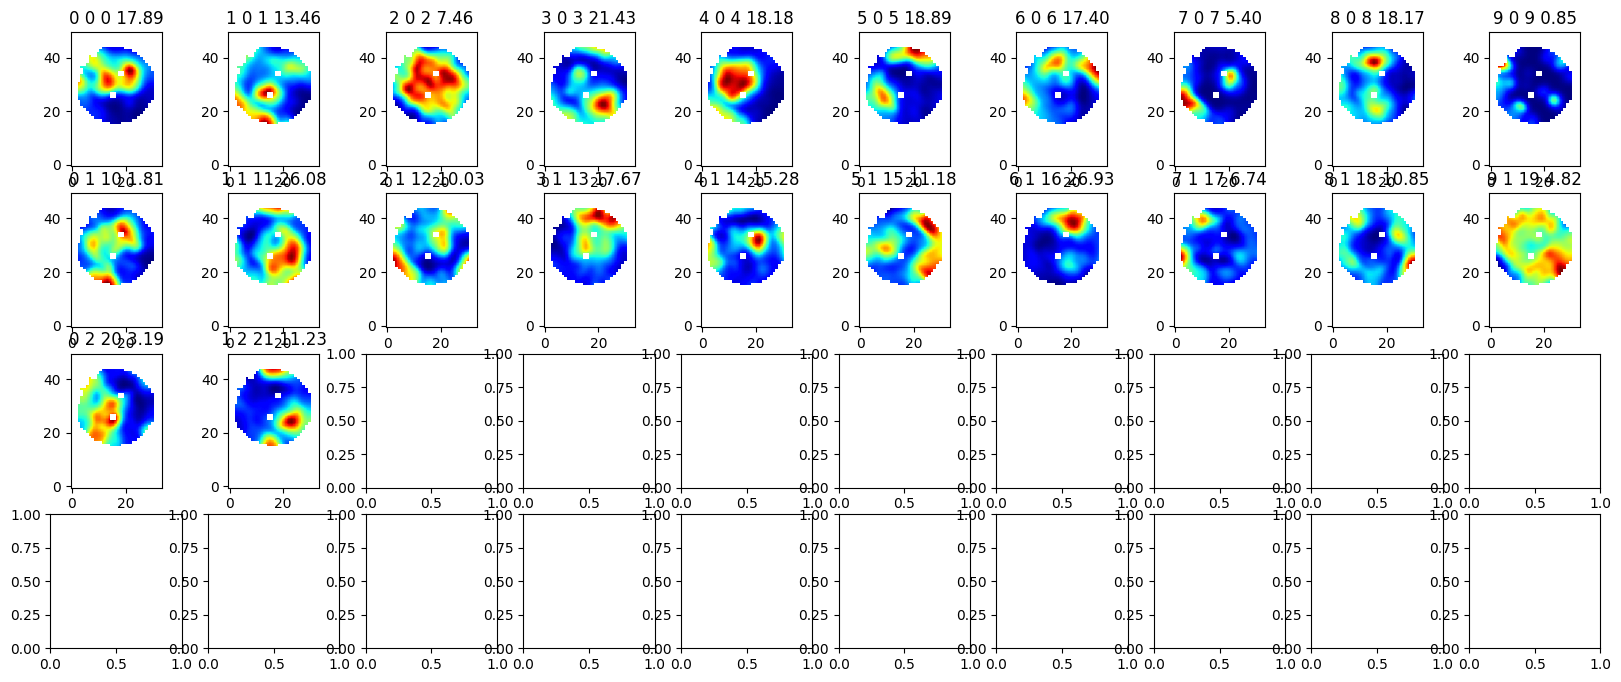

In [14]:
xSize=10
ySize=4
offset=0
fig,axis = plt.subplots(ySize,xSize,figsize=(xSize*2,ySize*2))
for i in range(res.shape[0]):
    x=i%xSize
    y=int(i/xSize)

    axis[y,x].imshow(res[i,:,:].T,cmap='jet',origin='lower')
    axis[y,x].set_title("{} {} {} {:.2f}".format(x,y,i,np.nanmax(res[i,:,:])))

In [15]:
conditions = ["circ80","circ80_1","circ80_2","task","task_1","task_2","light","light","dark","dark","light_1","light_2","dark_1","dark_2","all_light","all_light_1","all_light_2","all_dark","all_dark_1","all_dark_2"]
onlyArena = [False,False,False,False,False,False,False,True,False,True,True,True,True,True,True,True,True,True,True,True]
keys = ["circ80","circ80_1","circ80_2","task","task_1","task_2","light","light_arena","dark","dark_arena","light_1","light_2","dark_1","dark_2","all_light","all_light_1","all_light_2","all_dark","all_dark_1","all_dark_2"]

In [16]:
%%time
myMaps = {}
for key,cond,onlyArena in zip(keys,conditions,onlyArena):
    print(key,cond,onlyArena)
    myMaps[key] = np.concatenate([getMaps(ses,sSes,cond,onlyArena) for ses,sSes in zip(myProject.sessionList,sSesList)])

circ80 circ80 False
circ80_1 circ80_1 False
circ80_2 circ80_2 False
task task False
task_1 task_1 False
task_2 task_2 False
light light False
light_arena light True
dark dark False
dark_arena dark True
light_1 light_1 True
light_2 light_2 True
dark_1 dark_1 True
dark_2 dark_2 True
all_light all_light True
all_light_1 all_light_1 True
all_light_2 all_light_2 True
all_dark all_dark True
all_dark_1 all_dark_1 True
all_dark_2 all_dark_2 True
CPU times: user 8min 41s, sys: 45 s, total: 9min 26s
Wall time: 9min 26s


In [17]:
print(myMaps.keys())
[myMaps[k].shape for k in myMaps]

dict_keys(['circ80', 'circ80_1', 'circ80_2', 'task', 'task_1', 'task_2', 'light', 'light_arena', 'dark', 'dark_arena', 'light_1', 'light_2', 'dark_1', 'dark_2', 'all_light', 'all_light_1', 'all_light_2', 'all_dark', 'all_dark_1', 'all_dark_2'])


[(1080, 34, 50),
 (1080, 34, 50),
 (1080, 34, 50),
 (1080, 34, 50),
 (1080, 34, 50),
 (1080, 34, 50),
 (1080, 34, 50),
 (1080, 34, 50),
 (1080, 34, 50),
 (1080, 34, 50),
 (1080, 34, 50),
 (1080, 34, 50),
 (1080, 34, 50),
 (1080, 34, 50),
 (1080, 34, 50),
 (1080, 34, 50),
 (1080, 34, 50),
 (1080, 34, 50),
 (1080, 34, 50),
 (1080, 34, 50)]

In [19]:
fn=myProject.dataPath+"/results/cell_classification.csv"
ct = pd.read_csv(fn)
ct

,id,session,subject,valid,cellType,meanRate,shank,layer
0,mn5824-20112020-0107_80,mn5824-20112020-0107,mn5824,False,NaN,9.201345,4,pyr
1,mn5824-20112020-0107_90,mn5824-20112020-0107,mn5824,False,NaN,8.236764,3,pyr
2,mn5824-20112020-0107_92,mn5824-20112020-0107,mn5824,True,pyr,7.885922,4,pyr
3,mn5824-20112020-0107_96,mn5824-20112020-0107,mn5824,False,NaN,4.153462,1,dn
4,mn5824-20112020-0107_98,mn5824-20112020-0107,mn5824,False,NaN,3.411940,4,pyr
...,...,...,...,...,...,...,...,...
1263,mn9686-01112021-0106_238,mn9686-01112021-0106,mn9686,False,NaN,4.669745,7,dn
1264,mn9686-01112021-0106_240,mn9686-01112021-0106,mn9686,False,NaN,9.647625,2,pyr
1265,mn9686-01112021-0106_241,mn9686-01112021-0106,mn9686,False,NaN,16.161014,2,pyr
1266,mn9686-01112021-0106_242,mn9686-01112021-0106,mn9686,True,pyr,5.270951,1,pyr


In [20]:
ct[ct.cellType=='int'].shape


(188, 8)

In [21]:
1268-188

1080

## Save these matrices for later use

Since it takes some time to calculate these maps, autocorrelations and firing rate maps, we can save the results.


In [22]:
fn=myProject.dataPath+"/results/myMaps.pickle"
print("Saving:",fn)
with open(fn, 'wb') as handle:
    pickle.dump(myMaps, handle)

Saving: /ext_drives/d80/Jazi_etal_2023_noInter/autopi_ca1/results/myMaps.pickle


In [23]:
print('myMaps was created!')

myMaps was created!


## Plot some maps as a sanity check

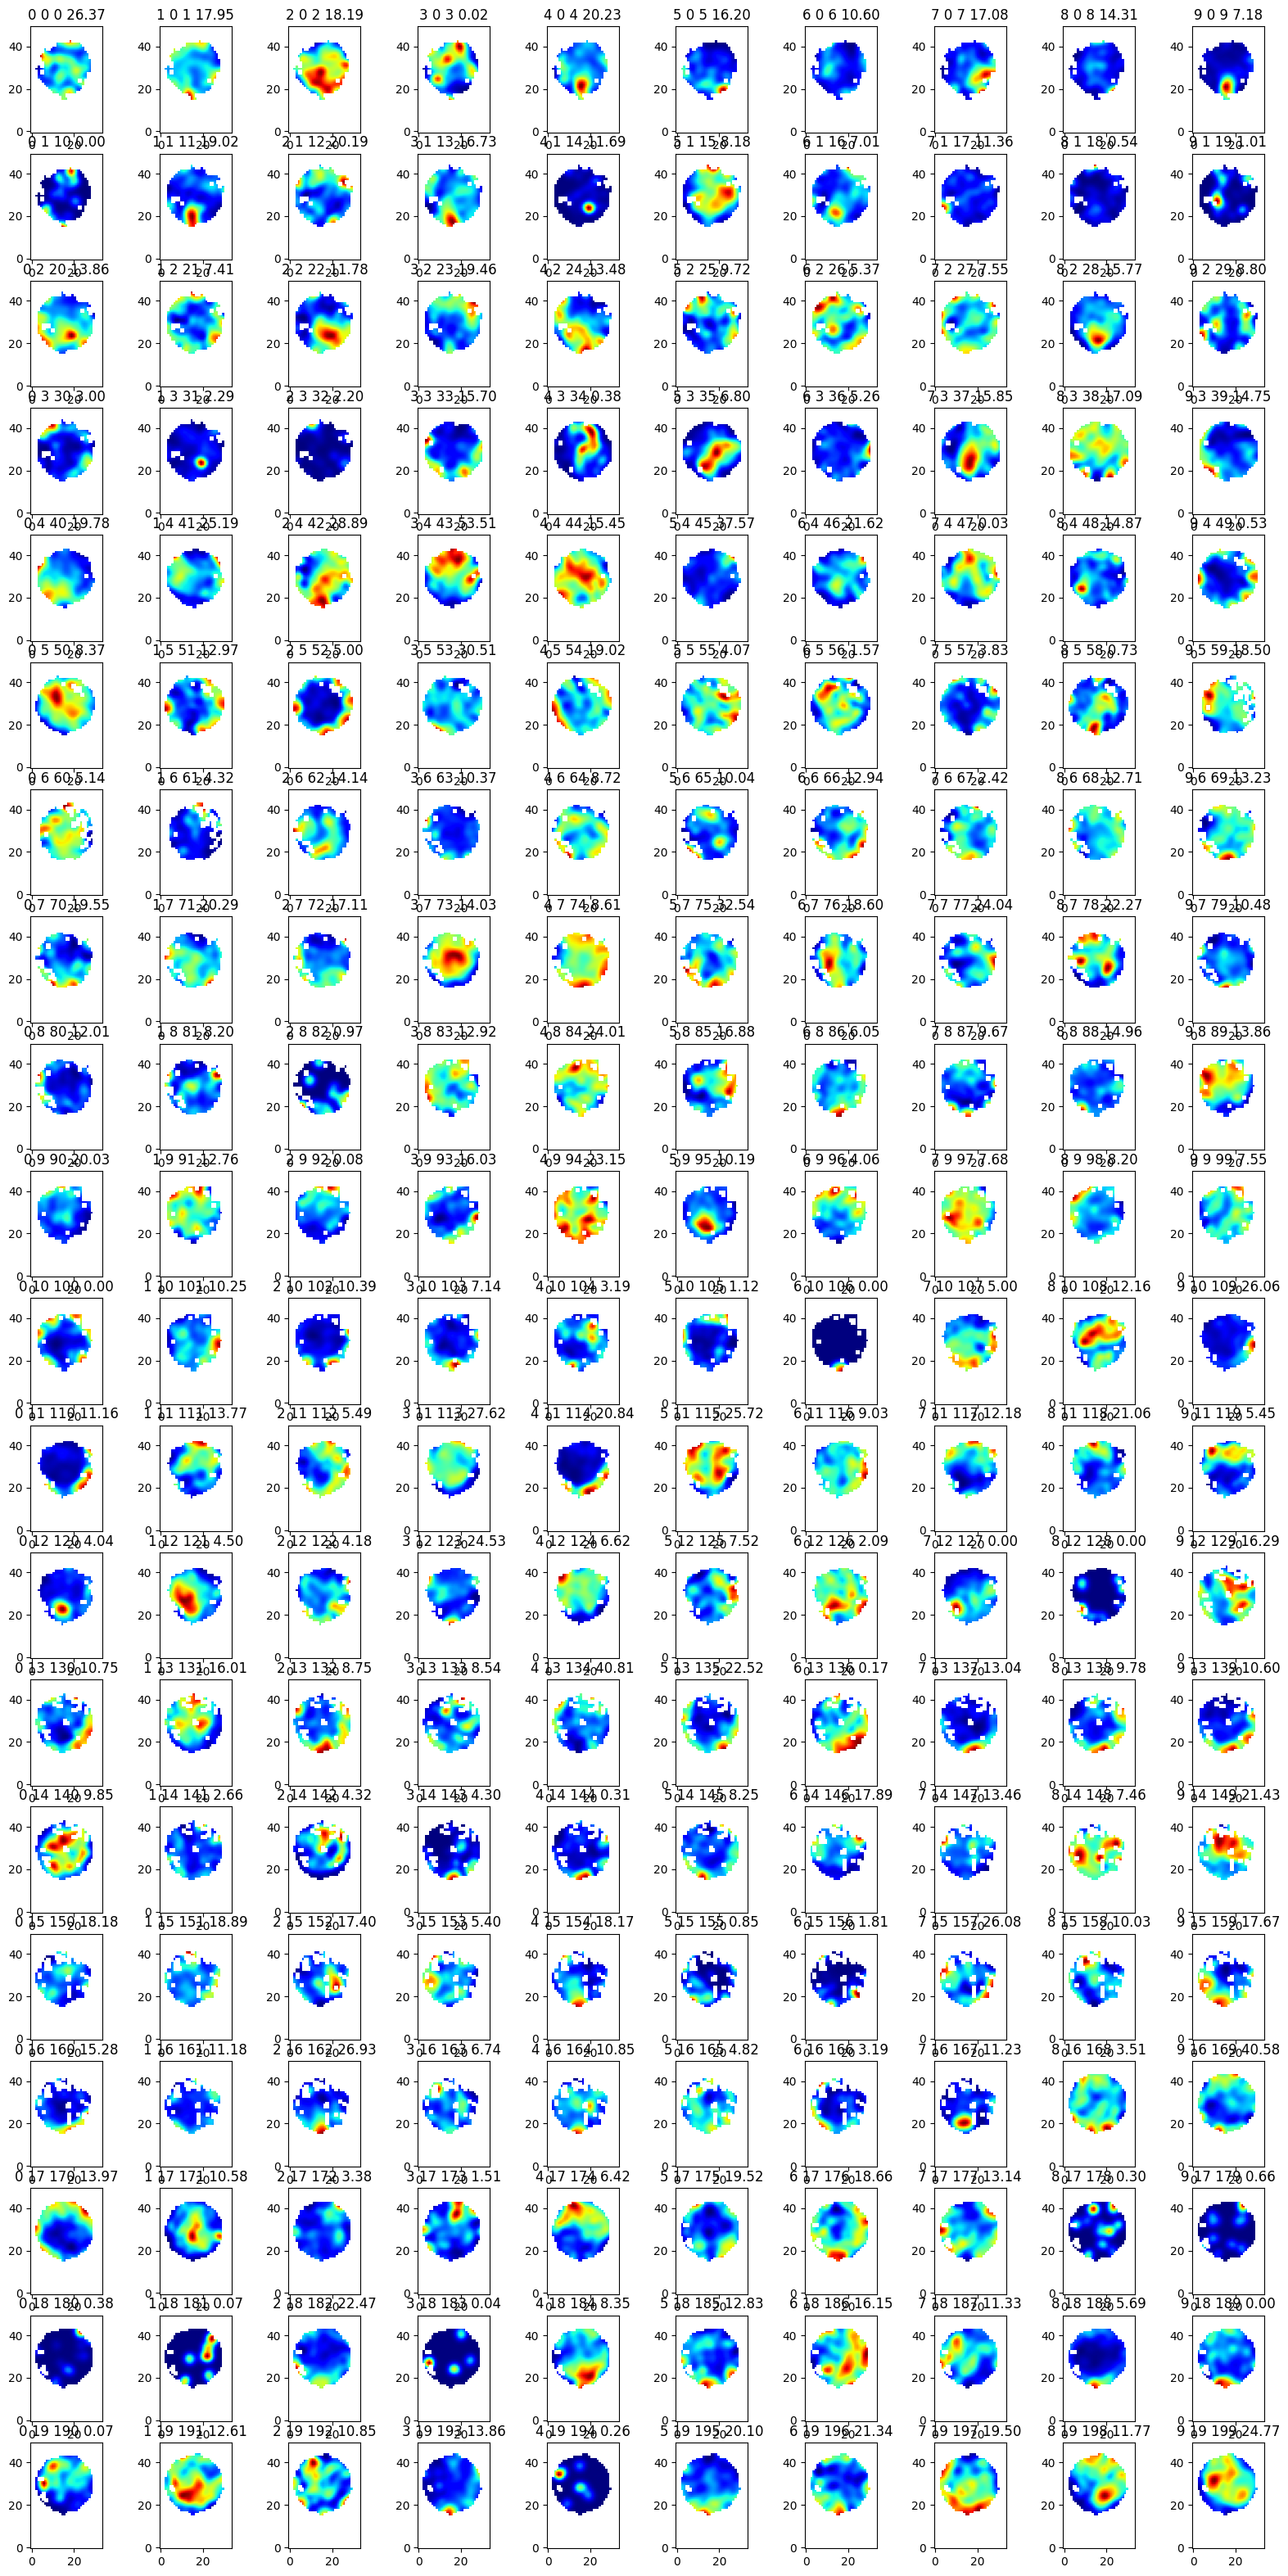

In [24]:
xSize=10
ySize=20
offset=0
fig,axis = plt.subplots(ySize,xSize,figsize=(xSize*2,ySize*2))
for y in range(ySize):
    for x in range(xSize):
        index = y*xSize+x+offset
        axis[y,x].imshow(myMaps["all_dark"][index,:,:].T,cmap='jet',origin='lower')
        axis[y,x].set_title("{} {} {} {:.2f}".format(x,y,index,np.nanmax(myMaps["circ80"][index,:,:])))